# Measuring grain sizes

In this notebook we will demonstrate how we can use the [scikit-image library](https://scikit-image.org/) to determine grain sizes from micrographs and how to use [matplotlib](https://matplotlib.org/) to visualize the results.

Concretely, we will look at:
* what is an image
* how to import images with [pillow](https://python-pillow.org/)
* how to make histograms from images
* how to threshold images and deciding on thresholds
* how to clean up images
* how to plot multiple images on top of eachother and create custom color maps
* how to segment different contiguous regions
* a bit more advanced segmentation with watershed
* measuring and plotting properties of segmented images
* exporting tables of properties

## Import some libraries and define settings

In [1]:
%matplotlib inline

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["image.cmap"] = "Greys_r"

In [435]:
2**16-1

65535

## What is an image?
An image is simply a 2D array of numbers.
Pixels are rows and columns, and the pixel intensity is represented by a number.

There are different ways to classify images:
* color
    * **grayscale** - one value per pixel
        * value corresponds linearly to pixel "intensity"
    * **color** - three values red, green, blue (RGB)
        * sometimes there is a 4th "channel" - alpha, to indicate translucency
* pixel depth
    * 8-bit: pixel values are integers ranging from 0 - 255 (2^8 - 1)
    * 16-bit: pixel values range from 0 - 65535 (2^16 - 1)
    * float: intensities can be any decimal that can be represented with 64 bits, usually scaled from 0-1
* file formats
    * there are many ways to store an image to disk (.png, .jpg, .tiff, ...)
    * they encode the same type of information but in a different way, often using compression
    * different file format may support different pixel depths
    * jpg: always 8-bit RGB, lossy compressed. Not good for images with sharp edges.
    * tiff: lossless storage, supports rich metadata
    
We can create some examples of images using numpy:

(4, 3)
[[  0 100 255]
 [100   0   0]
 [ 50  50 255]
 [255   0 255]]


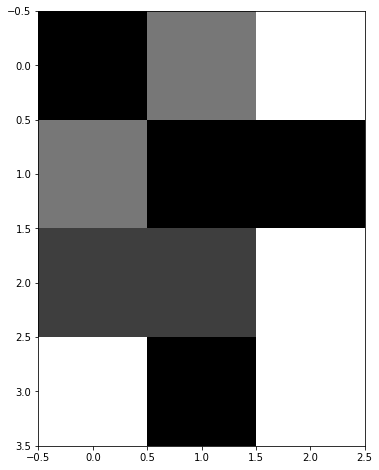

In [439]:
# small grayscale image
grayscale = np.array([[0, 100, 255],
                      [100, 0,   0],
                      [50, 50,  255],
                      [255, 0,  255],
                     ], dtype=np.uint8)
print(grayscale.shape)
print(grayscale)
plt.imshow(grayscale)

Matplotlib doesn't care what kind of data is stored in our array. We can convert 8-bit to floats 0-1 by dividing.

float64
1.0
0.0


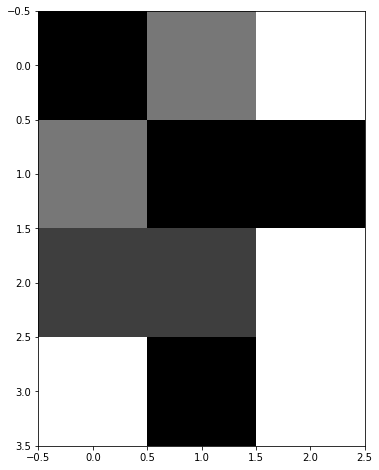

In [443]:
image = grayscale / 255
print(image.dtype)
print(image.max())
print(image.min())
plt.imshow(image)

Note that the coloring of a grayscale image is arbitrary. We can map the intensities to another colormap. A number are pre-defined in matplotlib. We can also plot corresponding colorbars to the side of our images

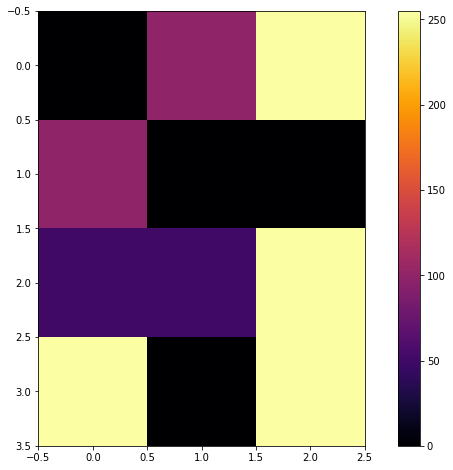

In [441]:
fig, ax = plt.subplots()
im = plt.imshow(grayscale, cmap="inferno")
fig.colorbar(im, ax=ax)

Matplotlib can also plot RGB images but then it expects values between 0-1 for red, green and blue. RGBA images can also be plot by adding a 4th value.

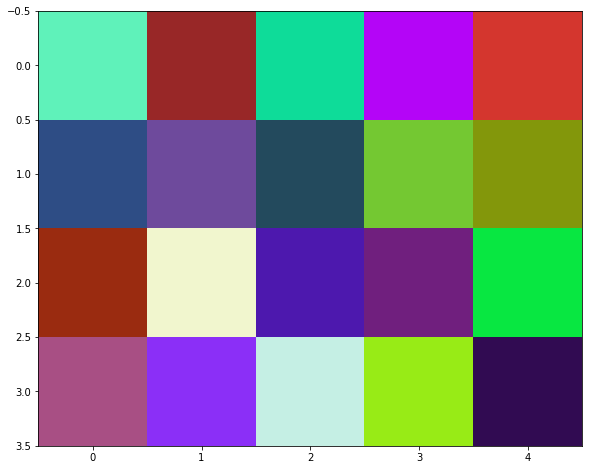

In [454]:
# RGB image
np.random.seed(42)
# create a random (4x5) RGB image
rgb_image = np.random.rand(4, 5, 3)
plt.imshow(rgb_image)

## Importing images
For importing images an easy library to use is PIL. 
We can directly visualize the image in a jupyter notebook simply by typing the variable name.

We will analyze an image of grains to see whether we can separate the grains and measure their size. Do you already have some ideas how we could approach this?

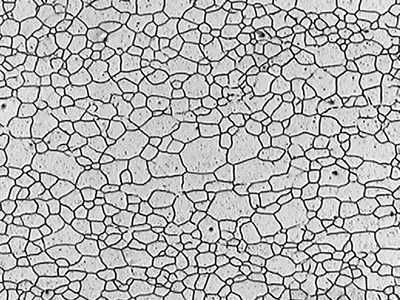

In [455]:
image = Image.open("./grain_image_2.jpg")
image

PIL imports the image as an image object, we can convert this in a very simple way to a numpy array and check the information inside.

In [456]:
image_data = np.array(image)
print(image_data.shape)
print(image_data.max())
print(image_data.min())

(300, 400, 3)
255
0


We imported a jpg, so the data stored inside each pixel is an RGB value ranging from 0-255. Since color is not important in this image, we convert this to grayscale. We use `skimage.color.rgb2gray` which basically takes a weighted sum of red, green and blue, which takes into consideration our eye's sensitivity to different colors. scikit-image will also scale the range automatically from 0-1, creating a float image.

(300, 400)
1.0
0.0


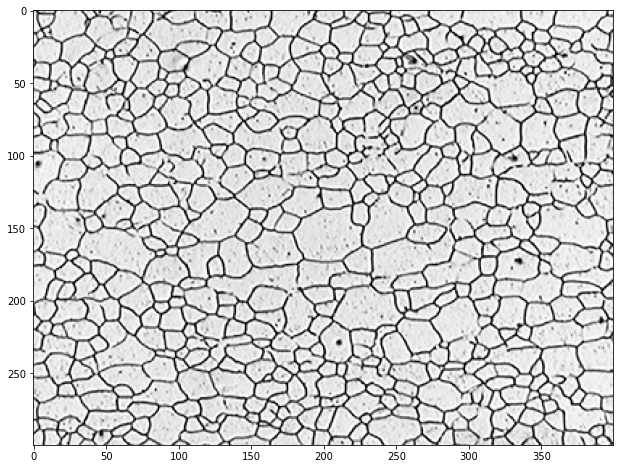

In [457]:
from skimage.color import rgb2gray
gray = rgb2gray(image_data)
print(gray.shape)
print(gray.max())
print(gray.min())
plt.imshow(gray)

Maybe what we can do as a first step is separate the grain boundaries from the grain interior using thresholding. The grain boundaries are clearly darker than the grain interiors, so we may be able to separate this easily by defining some cut-off value. Above the value, everything is grain, below everything is boundary. But where to we put this threshold?

A convenient tool to inspect the kinds of intensities we have in the image are histograms. With matplotlib this can be done in a very convenient way using the `hist` method. You can specify how many bins you want, and the method returns the histogram value, the bin value (in case you want to use these somewhere else) and the matplotlib object.

(array([ 3144.,   765.,   689.,   809.,   727.,   714.,   923.,   783.,
          984.,   774.,  1127.,   767.,   926.,   960.,   744.,   982.,
          907.,   680.,   905.,   862.,  1070.,   643.,   835.,   875.,
          863.,   884.,   947.,   944.,   941.,   994.,  1240.,  1113.,
         1030.,  1363.,  1680.,  2171.,  2384.,  3330.,  4972.,  7031.,
        11402., 10362.,  9136.,  7074.,  5109.,  3964.,  3935.,  2952.,
         2688.,  8896.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

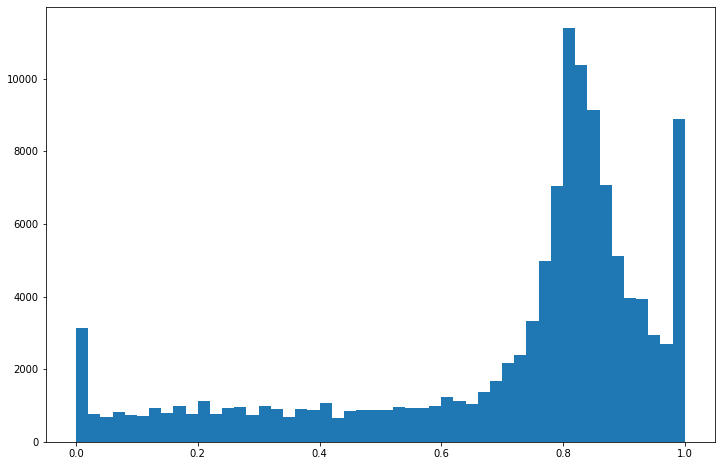

In [459]:
# use ravel, otherwise each pixel-row in the image will be considered for a separate histogram
plt.hist(gray.ravel(), bins=50)

The histogram tells us most of the pixel intensities center around 0.8. We can also see a lot of pixels are completely white while others are completely black. The best separation will likely be around 0.6, but how do we decide an optimal value? Luckily there are a number of strategies to determine an "optimal" threshold value and we can directly check all those implemented in scikit image in the following way:

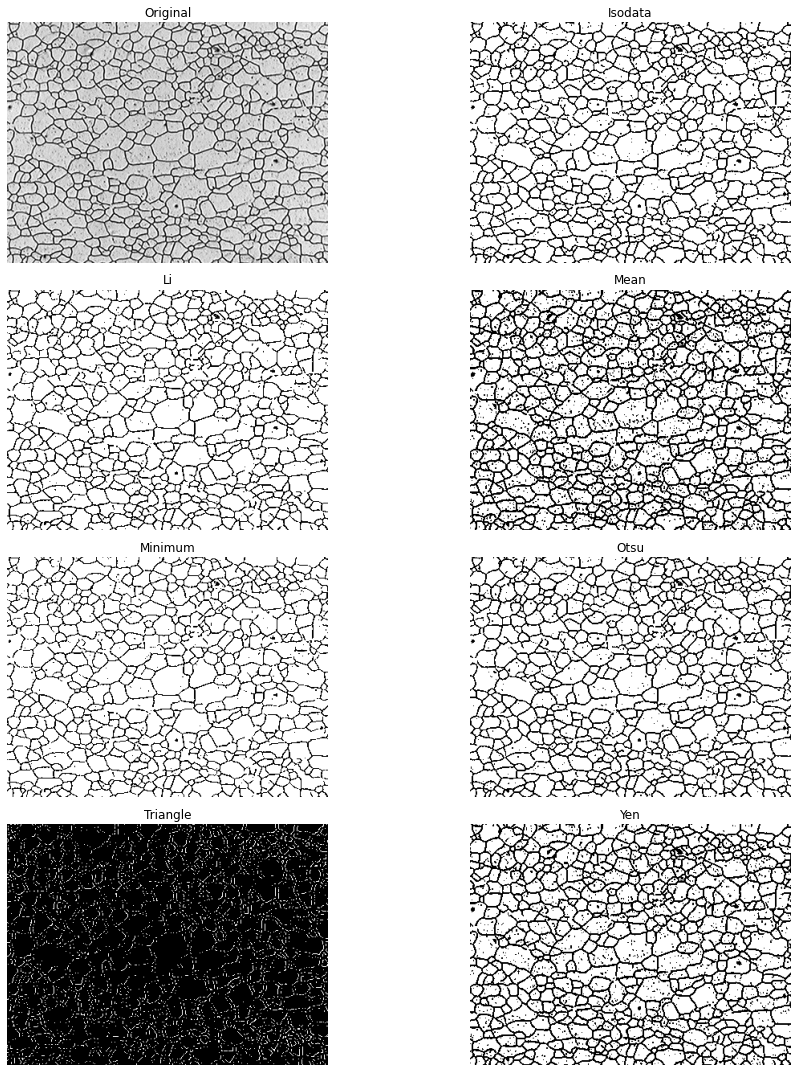

In [460]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(gray, figsize=(15, 15), verbose=False)
plt.show()

Here it depends a bit on our own preferences whether we want black to cut into our grains or whether we want to miss some faint grain boundaries. I decided to continue with the mean thresholding. As it turns out, this determines a threshold value of 0.71. We then create a thresholded image by comparing the gray value image to the threshold value. This creates a "boolean" image, where each pixel is True (the pixel intensity is larger than 0.7 = grain interior) or False (the pixel intensity is smaller than 0.7 = boundary or inclusion)

0.7098666573660131
bool


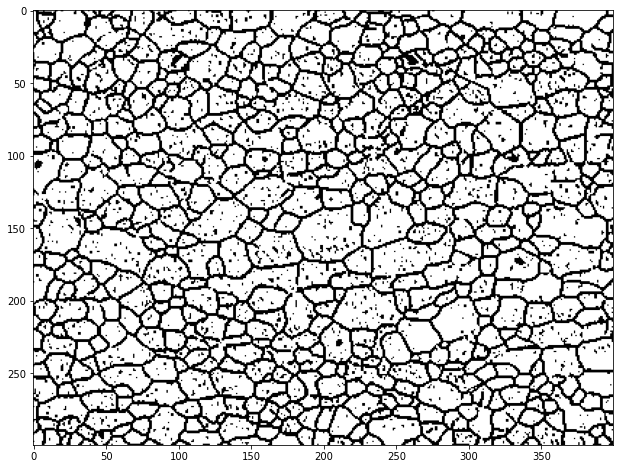

In [462]:
from skimage.filters import threshold_mean

tresh = threshold_mean(gray)
print(tresh)
binary = gray > tresh
print(binary.dtype)
plt.imshow(binary)

## Cleaning up the image

There are a lot of little black spots in our grains due to little inclusions. Fortunately it is quite easy to clean those up using the scikit-image morphology functions. In short, these can be used to expand or shrink black/white regions respectively according to some rules. We won't go into too much detail but experiment with erosion and dilation. We will use area_closing to remove areas that are smaller than a set number of pixels.

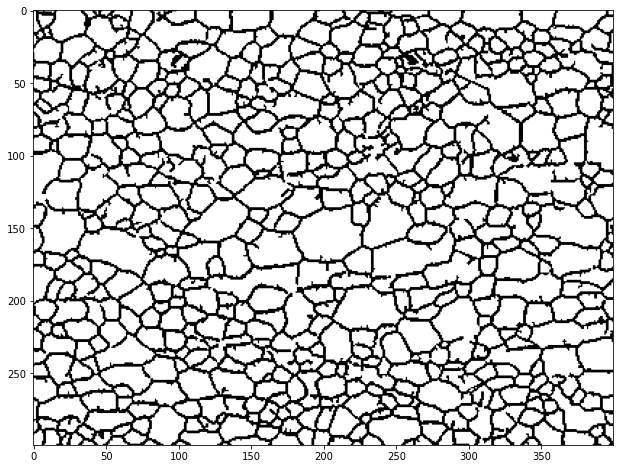

In [463]:
from skimage.morphology import area_closing, area_opening, erosion, dilation

cleaned = area_closing(binary, area_threshold=100)
plt.imshow(cleaned)

## Plotting images on top of eachother and custom color maps
Let's check if our cleaned boolean image still matches ok with our original image by plotting them on top of eachother. Since our grains are white in our boolean image, we will not be able to see anything of the image plotted below. Let's create a custom RGBA color map that is transparent at 0 and opaque at 1.

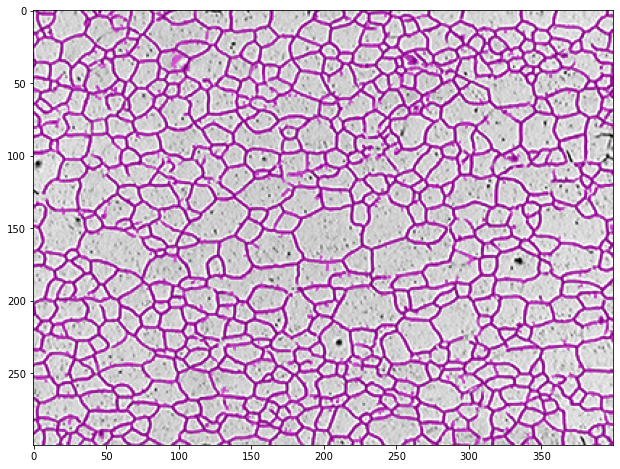

In [467]:
from matplotlib import colors
alpha = np.arange(256)/255 # np.arange(4) = [0,1,2,3]
ones = np.ones((256))  # an array of 1 256 elements long
zeros = np.zeros((256))  # an array of 0 256 elements long
cmap_custom = np.c_[ones, zeros, ones, alpha]
cmap = colors.ListedColormap(cmap_custom) # this creates our custom map

fig, ax = plt.subplots()
ax.imshow(image_data)
ax.imshow(cleaned == 0, cmap=cmap, alpha=0.5)  # plot where cleaned is black and make a bit transparent.

## Segmenting contiguous regions.
In principle all we need is for the different connected white regions to be joined together as grains. So what we need to do is *label* the white pixels with a number that will indicate the "grain" it belongs to. This is best performed using scipy's ndimage module which contains the `label` method. Note that we define a "structure", which  defines how "contiguity" should be defined. If we say np.ones((3, 3)) we indicate that all 8 pixels around each pixel should be considered for contiguity. We could also limit contiguity more and say we don't want the corner elements. We could construct this matrix manually, but easier is using scikit image's `disk`.

In [472]:
from skimage.morphology import disk

square = np.ones((3, 3))
selem = disk(1)
print("Consider diagonal elements contiguous:")
print(square)
print("Don't consider diagonal elements contiguous:")
print(selem)

Consider diagonal elements contiguous:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Don't consider diagonal elements contiguous:
[[0 1 0]
 [1 1 1]
 [0 1 0]]


In [473]:
import scipy.ndimage as ndi

In [546]:
labels_simple, features = ndi.label(cleaned, structure=selem)

Labels now contains an array the size of the input image (cleaned) with each pixel containing an integer corresponding to its "label" - the grain in which it was segmented. We can visualize the labels as an image

568


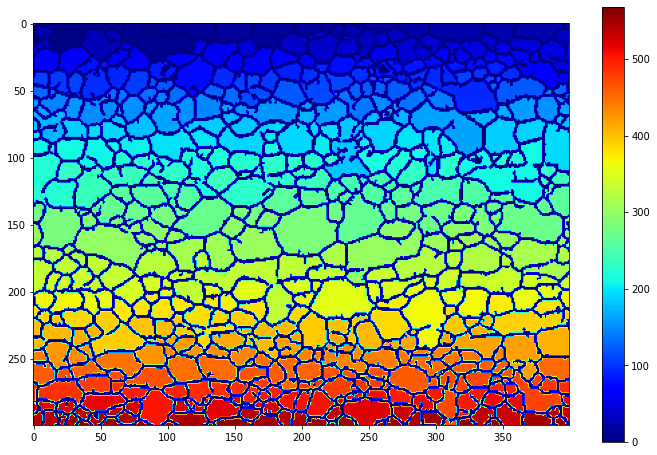

In [547]:
print(features)
fig, ax = plt.subplots()
im = ax.imshow(labels_simple, cmap="jet")
fig.colorbar(im, ax=ax)

We have detected 568 grains, and they are colored from blue to red from top to bottom. It may be easier to detect the different grains by converting the labels to random rgb values, which can be done with `skimage.label2rgb`. Note that some grains next to eachother may by chance still get the same color. And that's it, we have separated out the pixels for each grain individually, we could then perform various metrics on this. This we will do at the end, first we will look at a slightly more advanced approach to hopefully slightly improve our result.

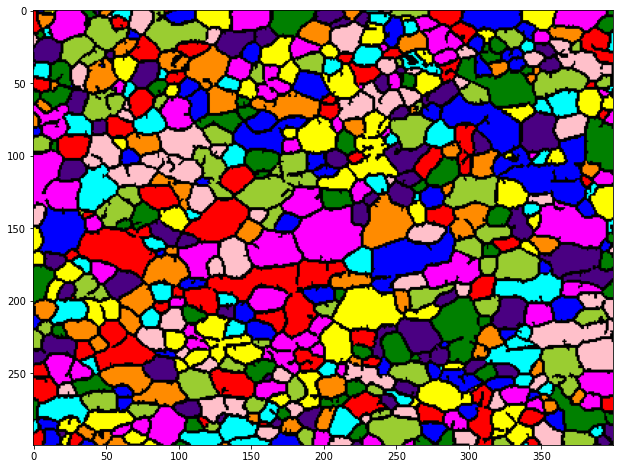

In [548]:
from skimage.color import label2rgb
colors = label2rgb(label = labels_simple, bg_label=0)
plt.imshow(colors)

## More advanced segmentation with watershed

You can see that some grain boundaries have little gaps in them, which incorrectly connects some grains by contiguity. We can try to separate those out with the watershed algorithm. With watershed we will try to pinpoint the centers of grains and grow those outwards (as lakes growing) in a "landscape". The algorithm stops when the different "waterlines" touch.

First we need some "topology" map of the image. We will use the distance transform, which measures how far away each pixel is from the nearest black (background) pixel. This transform is again in the scipy.ndimage module.

In [479]:
dist = ndi.distance_transform_edt(cleaned)

If we plot the negative distance, we can image each grain being kind of like a valley that needs to be filled up with water. But we still need "fountains" to tell us where to start to fill the water from.

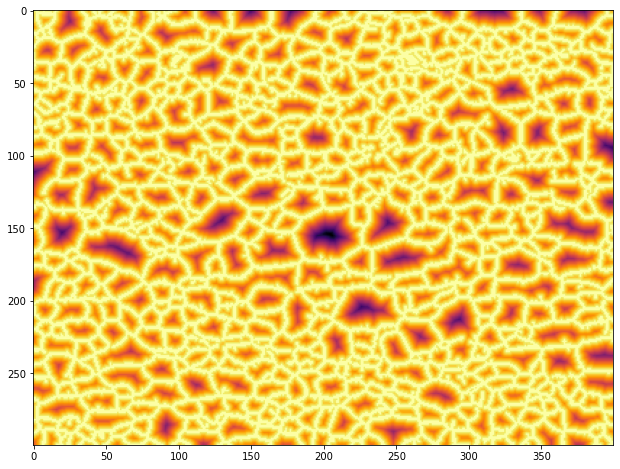

In [481]:
plt.imshow(-dist, cmap="inferno")

A good place to add fountains is at the bottom of the valleys; we can find these using a peak finding algorithm.

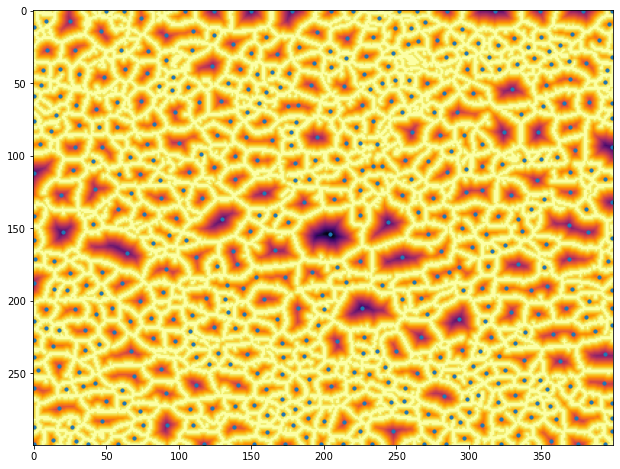

In [549]:
from skimage.feature import peak_local_max
from skimage.filters import gaussian
# we smooth the distance map a bit to have less noise in peak finding
coords = peak_local_max(gaussian(dist, sigma=1.5), min_distance=5, threshold_rel=0.1, exclude_border=False)
# to get the fountain coordinates in an image which is supplied to watershed
mask = peak_local_max(gaussian(dist, sigma=1.5), min_distance=5, threshold_rel=0.1,
                      exclude_border=True, indices=False)
labels_water, _ = ndi.label(mask)

plt.imshow(-dist, cmap="inferno")
plt.scatter(coords[:,1], coords[:,0], s=10)

Now we just provide the labeled mask (each non-zero pixel has a unique integer and corresponds to a fountain) to the watershed algorithm.

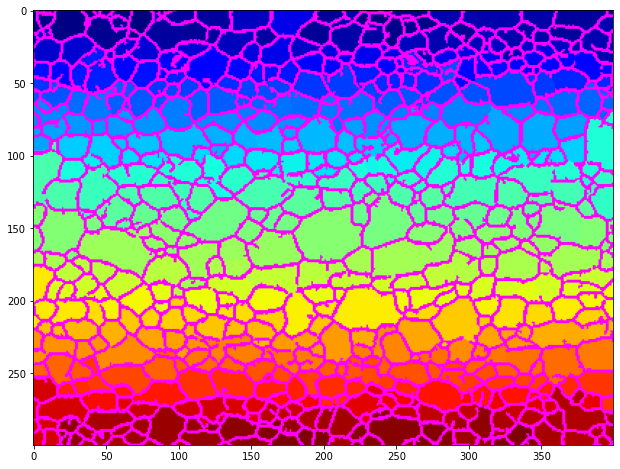

In [557]:
from skimage.segmentation import watershed
water = watershed(-dist, labels_water, connectivity=selem)
fig, ax = plt.subplots()
ax.imshow(water, cmap="jet")
ax.imshow(cleaned==0, cmap=cmap)

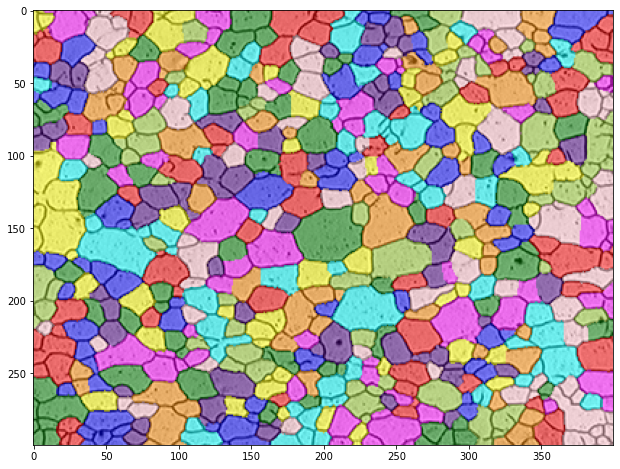

In [559]:
fig, ax = plt.subplots()
#the simple one
ax.imshow(image_data)
colors = label2rgb(water, bg_label=0, bg_color=(0,0,0))
ax.imshow(colors, alpha=0.5)

## Measuring properties of the regions
Once we have a labeled image, it is easy to measure various properties

In [560]:
from skimage.measure import regionprops_table, regionprops

In [561]:
#to check the properties that can be measured
regionprops?

In [562]:
properties=['label', 'area', 'major_axis_length', "orientation", "perimeter"]
metrics = regionprops_table(water, properties = properties)
metrics_simple = regionprops_table(labels_simple, properties=properties)

In [563]:
# to map the properties to the labeled image
area = metrics["area"][water-1]
area_simple = metrics_simple["area"][labels_simple-1]

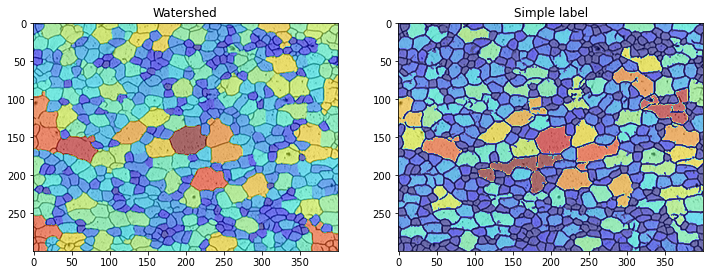

In [565]:
fig, ax = plt.subplots(ncols=2)

vmin = np.sqrt(area.min())
vmax = np.sqrt(area.max())

ax[0].set_title("Watershed")
ax[0].imshow(image_data)
ax[0].imshow(np.sqrt(area), cmap="jet", alpha=0.5, vmin=vmin, vmax=vmax)
ax[1].set_title("Simple label")
ax[1].imshow(image_data)
ax[1].imshow(np.sqrt(area_simple), cmap="jet", alpha=0.5, vmin=vmin, vmax=vmax)

Watershed can do slightly better on some grains where the separation is not completely clear. However, it seems to perform worse on the boundary.

We can check the sizes evolution with a histogram

273.972602739726
154.71302816901408


(0.0, 1400.0)

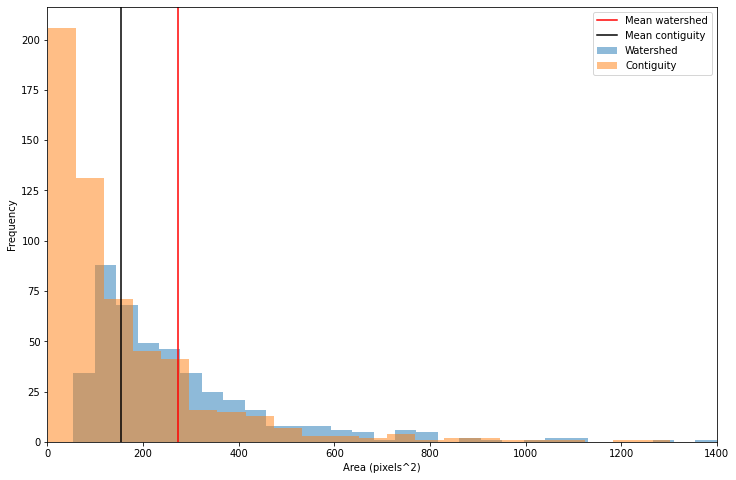

In [569]:
fig, ax = plt.subplots()
value = metrics["area"]
value_2 = metrics_simple["area"]
y, x, bars = ax.hist(value, bins=30, alpha=0.5, label="Watershed")
y_2, x_2, bars_2 = ax.hist(value_2, bins=30, alpha=0.5, label="Contiguity")
ax.set_ylabel("Frequency")
ax.set_xlabel("Area (pixels^2)")
ax.axvline(np.mean(value), color="red", label="Mean watershed")
ax.axvline(np.mean(value_2), color="black", label="Mean contiguity")
print(np.mean(value))
print(np.mean(value_2))
ax.legend()
ax.set_xlim(0, np.max(value))

## Exporting data to excel
You can easily export the measurements to an excel or csv file

In [568]:
import pandas as pd
df = pd.DataFrame(metrics)
df

label  area  major_axis_length  orientation   perimeter
0        1   337          27.184911     1.254971   85.941125
1        2   207          25.646619    -1.523182   62.284271
2        3   174          17.333309    -0.671593   53.213203
3        4   522          32.961262    -1.238615  106.805087
4        5   249          34.720171     1.242897   85.284271
..     ...   ...                ...          ...         ...
433    434   763          41.858594     1.565249  117.254834
434    435   344          26.896903     1.545161   79.455844
435    436   193          19.400994    -1.082330   57.941125
436    437   304          29.047864    -1.415711   78.870058
437    438   344          43.015018    -1.517395   97.355339

[438 rows x 5 columns]

In [428]:
df.to_excel("grain_measurements.xlsx")

In [434]:
!if [ -f grain_measurements.xlsx ];then echo file exists; fi

file exists
